In [356]:
import pandas as pd
import numpy as np
from pandas_datareader import data, wb
import datetime

In [291]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


`%matplotlib` prevents importing * from pylab and numpy


In [342]:
#
# random time series
#
date = pd.date_range(start='2015-01', end='2015-05', freq='D')
price = np.random.randint(-100, 100, size=len(date))
df = pd.DataFrame(price, index=date, columns=['close'])
df = df.cumsum()

In [357]:
#
# Real ticker data
#
start = datetime.datetime(2014, 1, 1)
end = datetime.datetime.now()

price_data = data.DataReader('SPY', 'yahoo', start, end)
adjclose_series = price_data['Adj Close']
adjclose_series.name = 'close'

df = pd.DataFrame(adjclose_series)

In [343]:
df

,close
2015-01-01,29
2015-01-02,78
2015-01-03,163
2015-01-04,69
2015-01-05,132
2015-01-06,62
2015-01-07,102
2015-01-08,177
2015-01-09,228
2015-01-10,292


In [361]:
box_size = 2

box_start = 0
box_start_idx = None

box_end = 0
box_quantity = 0

temp_l = []

# Simple renko algorihtm


# 
for i in range(len(df)):
    if box_start == 0:
        box_start = df.close[i]

    else:
        box_start = box_start
        price_move = df.close[i] - box_start
        
        # First of all we need to set box size. 
        # Then calculate price movement. 
        # If price movement is more or equal than box size - renko bar(or bars) will be added
        
        if np.abs(price_move) >= box_size:
            
            # After we calculate box_quantity(price move divided by box size)
            # This number defines how much renko bars will be registred
            box_quantity = np.int32(np.floor(np.abs(price_move / box_size)))
            box_index = df.close.index[i]

            for b in range(int(box_quantity)):
            # Let say, index is 2015-01-01, box_start = 100, box_quantity = 3, box size = 10, price move > 0
            # So renko bar 1 will have next parameters - 
            # 1)index 2015-01-01
            # 2)open = 100
            # 3)close = 110(box_start + box_size)
            # 4)type = up
            
            # Next renko bar will have next parameters -
            # 1)index 2015-01-01
            # 2)open = 110(previous renko bar close)
            # 3)close = 120(open + box_size)
            # 4)type = up
            
            # And so on..
            
            # After all we adding renko bars dict to list and convert it to DF
            
                if price_move > 0:
                    if box_end == 0:
                        d = {'index': box_index, 'open': box_start, 'close': box_start + box_size, 'type': 'up'}
                        box_end = d['close']
                        temp_l.append(d)
                        
                    else:
                        d = {'index': box_index + pd.DateOffset(hour=b), 'open': box_end, 'close': box_end + box_size,
                            'type': 'up'}
                        
                        box_end = d['close']
                        temp_l.append(d)

                if price_move < 0:
                    if box_end == 0:
                        d = {'index': box_index, 'open': box_start, 'close': box_start - box_size, 'type': 'down'}
                        box_end = d['close']
                        temp_l.append(d)
                        
                    else:           
                        d = {'index': box_index + pd.DateOffset(hour=b), 'open': box_end, 'close': box_end - box_size, 
                             'type': 'down'}
                        
                        box_end = d['close']
                        temp_l.append(d)
                        
            box_start = df.close[i]
            
result_df = pd.DataFrame(temp_l)

# ! Uncomment to allign renkos to dates(ugly looking)
#result_df.index = result_df['index']

del temp_l

high_l = []
low_l = []
for i in range(len(result_df)):
    if result_df.close[i] > result_df.open[i]:
        high_l.append(result_df.close[i])
        low_l.append(result_df.open[i])
        
    if result_df.close[i] < result_df.open[i]:
        high_l.append(result_df.open[i])
        low_l.append(result_df.close[i])
        
result_df['low'] = low_l
result_df['high'] = high_l

del low_l
del high_l

In [362]:
result_df

,close,index,open,type,low,high
0,171.980006,2014-01-24 00:00:00,173.980006,down,171.980006,173.980006
1,169.980006,2014-02-03 00:00:00,171.980006,down,169.980006,171.980006
2,167.980006,2014-02-03 01:00:00,169.980006,down,167.980006,169.980006
3,169.980006,2014-02-06 00:00:00,167.980006,up,167.980006,169.980006
4,171.980006,2014-02-07 00:00:00,169.980006,up,169.980006,171.980006
5,173.980006,2014-02-11 00:00:00,171.980006,up,171.980006,173.980006
6,175.980006,2014-02-18 00:00:00,173.980006,up,173.980006,175.980006
7,177.980006,2014-03-04 00:00:00,175.980006,up,175.980006,177.980006
8,175.980006,2014-03-13 00:00:00,177.980006,down,175.980006,177.980006
9,177.980006,2014-03-18 00:00:00,175.980006,up,175.980006,177.980006


In [363]:
import plotly.plotly as py
from plotly.tools import FigureFactory as FF
from datetime import datetime
import plotly.graph_objs as go

#py.sign_in('dmveden', 'rzbs7xw8ft')
py.sign_in('tmqr', '8rctfyu197')

fig = FF.create_candlestick(result_df.open, result_df.high, result_df.low, result_df.close, dates=result_df.index)
py.iplot(fig)

In [364]:
trace = go.Scatter(
    x = df.index,
    y = df.close
)

data = [trace]

# Plot and embed in ipython notebook!
py.iplot(data, filename='basic-line')

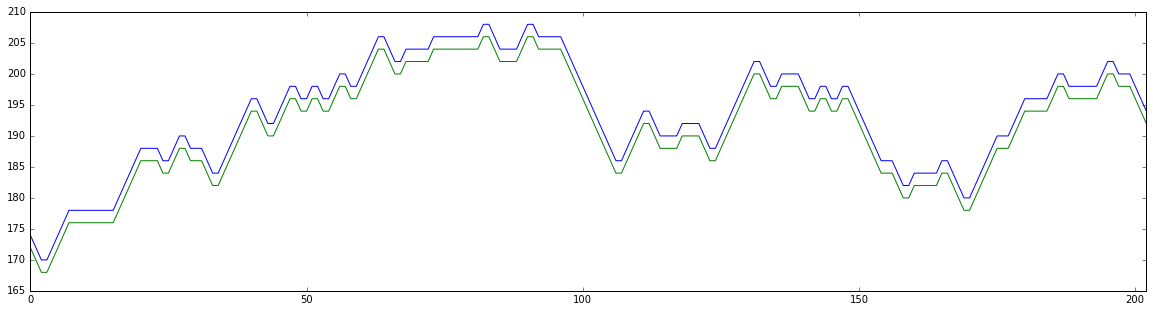

In [365]:
figsize(20,5)
result_df.high[:500].plot()
result_df.low[:500].plot()